<a href="https://colab.research.google.com/github/seonleeuni/mge51101-20205196/blob/master/RNN_GRU_with%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Making Synthetic time-series example

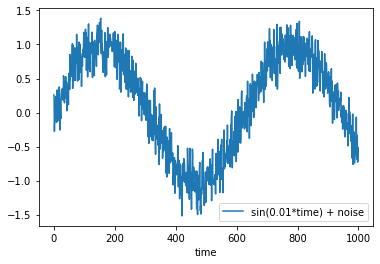

In [3]:
import torch

T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(),X.numpy(), label = "sin(0.01*time) + noise")
plt.legend()
plt.xlabel('time')
plt.show()

RNN 수행할 때 345번(training part)를 잘 보라는데 , 타임시리즈 데이터 적용시키려면


In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



tau = 20


features = torch.zeros((T-tau,tau))

#input = features
for i in range(tau):
  features[:,i] = X[i:(T-tau+i)]

input_len = features.size()[1]


train_num = 600
train_data= features[:train_num-tau-1,:]
test_data = features[train_num-tau:,:]



In [0]:
#model making RNN
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.relu = nn.ReLU()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.rnn(inputs, hidden)
        output = self.relu(output[:,-1])
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
# Hyperparameters
input_len = tau
n_hidden = tau

lr = 0.01
epochs = 200

model = RNN(input_len, n_hidden, 1, input_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [42]:
# training
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()
    
    for idx in range(train_num-tau-1):
        inputs = train_data[idx:idx+1].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
       
        target = train_data[idx]

        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 408.40619
loss: 21.91423


torch.Size([1000])

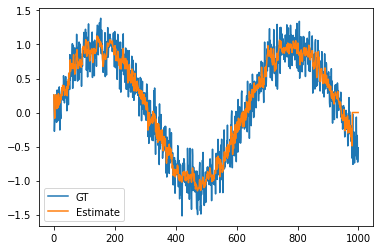

In [44]:
estimate = torch.zeros(1000)
estimate[0] = X[0]

hidden = model.initHidden()
for idx in range(T-tau-1):
        inputs = features[idx:idx+1].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        #output.size()
        estimate[idx+1] = output[0,0]
       
      
plt.plot(time.numpy(), X.detach().numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time.numpy(), estimate.detach().numpy(), label='Estimate');
plt.legend()
estimate.size()

torch.Size([1000])

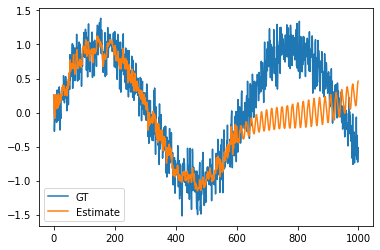

In [45]:
predictions = torch.zeros(1000)
predictions[:train_num] = estimate[:train_num]

inputs = predictions[train_num-tau:train_num].reshape(1, 1, -1) 
for idx in range(train_num-tau,T-tau):
  inputs = predictions[idx:idx+tau].reshape(1, 1, -1) 
  output, hidden = model(inputs, hidden)
  predictions[idx+tau] = output[0,3]

  


plt.plot(time.numpy(), X.detach().numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time.numpy(), predictions.detach().numpy(), label='Estimate');
plt.legend()
estimate.size()

In [0]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(self.relu(output[:,-1]))

        return output, hidden
    
    def initHidden(self):
       # weight = next(self.parameters()).data
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return torch.zeros(1, self.hidden_size)

In [0]:
# Hyperparameters
input_len = tau
n_hidden = tau

lr = 0.01
epochs = 200

model = GRU(input_len, n_hidden, 1, input_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [54]:
# training
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()
    
    for idx in range(train_num-tau-1):
        inputs = train_data[idx:idx+1].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
       
        target = train_data[idx]

        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 369.48605
loss: 21.85771


torch.Size([1000])

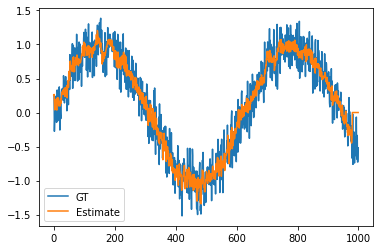

In [55]:
# validation
estimate = torch.zeros(1000)
estimate[0] = X[0]

hidden = model.initHidden()
for idx in range(T-tau-1):
        inputs = features[idx:idx+1].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        #output.size()
        estimate[idx+1] = output[0,0]
       
      
plt.plot(time.numpy(), X.detach().numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time.numpy(), estimate.detach().numpy(), label='Estimate');
plt.legend()
estimate.size()

torch.Size([1000])

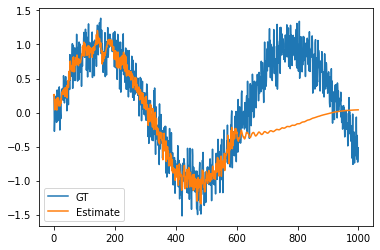

In [56]:
predictions = torch.zeros(1000)
predictions[:train_num] = estimate[:train_num]

inputs = predictions[train_num-tau:train_num].reshape(1, 1, -1) 
for idx in range(train_num-tau,T-tau):
  inputs = predictions[idx:idx+tau].reshape(1, 1, -1) 
  output, hidden = model(inputs, hidden)
  predictions[idx+tau] = output[0,3]

  


plt.plot(time.numpy(), X.detach().numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time.numpy(), predictions.detach().numpy(), label='Estimate');
plt.legend()
estimate.size()